# Space-time partial differential equation: Study of the diffusive equation (implicit methods)

In [1]:
# Importing relevant libraries 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
from nm_lib import nm_lib as nm
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# plt.style.use('dark_background')
plt.style.use('default')

def u(x, A=0.3): 
    """ 
    Initial condition for t=t0 when a = const

    Parameters
    ----------
    x : `array`
        Spatial axis. 
    A : `float`
        A constant of the initial condition (default = 0.02).
    
    Returns
    -------
    Equation 2
    """
    W = 0.1 
    x0 = 0
    return A*np.exp(-(x - x0)**2 / W**2)
    
x0 = -2.6 
xf = -x0

Let's consider now the viscous term in Burger's equation: 

$$\frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2}, \tag{1}$$

## 1- Apply an explicit method. 

What would be the CFL condition for a viscous term where $\nu$ is either a constant or an array that depends on $x$. We would like to solve equation (1) numerically for $x  [x_0, x_f]$ with $x_0 = −2.6$, $x_f = 2.6$, periodic boundary conditions and with the initial condition:

$$u(x,t=t_0) = A\exp(-(x-x_0)^2/W^2)   \tag{2}$$

with $A=0.3$, $W=0.1$, and $x_0=0$. __Suggestion__: Apply the first derivative upwind and the second downwind. Apply Von Newman analysis. Is it stable? What is the time-step dependence with $\Delta x$? 

<span style="color:pink">
We begin by applying the upwind and downwind derivative such that 

$$
\frac{u_j^{n+1} - u_j^n}{\Delta t} = \nu\frac{(u_{j+1}^n - 2u_j^n + u_{j-1}^n)}{\Delta x^2}
$$

Next, we apply Von-Newman analysis, 

$$
u_j^n = \xi^n e^{ikj\Delta x}, 
$$

which makes 

$$
e^{ikj\Delta x} \frac{\xi^{n+1} - \xi^n}{\Delta t} = \nu\xi^n e^{ikj\Delta x} \frac{e^{ik\Delta x} - 2 + e^{-ik\Delta x}}{\Delta x^2}. 
$$

We divide by $e^{ikj\Delta x}$ on both sides, to eliminate the term. 

$$
\frac{\xi^{n+1} - \xi^n}{\Delta t} = \nu\xi^n \frac{e^{ik\Delta x} - 2 + e^{-ik\Delta x}}{\Delta x^2}. 
$$

Next, we can rewrite the equation using that $e^{i\theta} = \cos\theta + i\sin\theta$, to get 

$$
\xi = 4\frac{\nu\Delta t}{\Delta x^2} \sin^2\left(\frac{k\Delta x}{2}\right) + 1.
$$

Requiering that $|\xi^n|^2 \leq 1$ for all $k$ means that 

$$
\left(4\frac{\nu\Delta t}{\Delta x^2} \sin^2\left(\frac{k\Delta x}{2}\right) + 1\right)^2 \leq 1
$$

This holds for all $k$ when, 

$$
\frac{16\nu^2\Delta t^2}{\Delta x^4} - \frac{4\nu\Delta t}{\Delta x^2} + 1 \leq 1 \\ 
\frac{16\nu^2\Delta t^2}{\Delta x^4} \leq \frac{4\nu\Delta t}{\Delta x^2} \\ 
\frac{4\nu\Delta t}{\Delta x^2} \leq 1, 
$$

making the CFL condition 

$$
\Delta t \leq \frac{\Delta x^2}{4\nu}. 
$$

The solution should remain stable for this condition.

</span>

<span style="color:pink">

We write a function which applies the first derivative upwind and the second downwind, and a function which implements the cfl condition just found. 

</span>

In [2]:
def deriv_up_down(xx, hh): 
    """
    Returns the second order derivative of hh with respect to xx

    Parameters
    ----------
    xx : `array`
        Spatial axis.
    hh : `array`
        Function that depends on xx.
    
    Returns
    -------
        The 2nd order derivative using first upwind and then downwind. 
        First gridpoint is ill calculated. 
    """
    dx = xx[1] - xx[0]
    return (np.roll(hh, -1) - 2*hh + np.roll(hh, 1))/dx**2

def cfl_adv_sst(a, x):

    r"""
    Computes the dt_fact, i.r. the condition found 

    Parameters
    ----------
    a : `float` or `array` 
        Multiply the right hand side of the Burger's eq. (viscosity term)
    x : `array`
        Spatial axis. 

    Returns
    -------
    `float`
        min(dx/|a|)
    """
    dx = np.diff(x)    # x[1] - x[0]
    return np.min(dx**2/(4*np.abs(a)))

How many steps are needed to reach a $t=1.8$ for $nump=128$? And $256$? 

In [3]:
def count_steps(nump, t_fin=1.8): 
    # nump = nint + 1
    x = np.arange(nump)/(nump-1.0) * (xf-x0) + x0
    dx = x[1] - x[0]

    # Count steps: 
    t = 0
    step = 0
    dt = dx**2 / 2     # depends on the nump
    print(f"Time step dependence for nump = {nump}: {dt}")
    while t <= t_fin: 
        t += dt 
        step +=1 

    return step 

nump_128 = 128 
nump_256 = 256
print(f"Steps needed to reach t = 1.8 for nump = {nump_128}: {count_steps(nump_128)}\n")
print(f"Steps needed to reach t = 1.8 for nump = {nump_256}: {count_steps(nump_256)}")

Time step dependence for nump = 128: 0.0008382416764833609
Steps needed to reach t = 1.8 for nump = 128: 2148

Time step dependence for nump = 256: 0.00020792003075740314
Steps needed to reach t = 1.8 for nump = 256: 8658


<span style="color:pink">

The number of steps needed to reach $t=1.8$ increases when the number of points increases, and in this case the number of steps quadruples as we double the number of points. 

</span>

## Choose one of the following options: 

## 2- Implicit methods.

In the [wiki](https://github.com/AST-Course/AST5110/wiki/Implicit-methods), we describe some implicit or semi-explicit methods that allow relaxing the CFL constraint on diffusive terms. Consider Newton-Rapson method and repeat the previous numerical experiment. For this, you will need to implement the following   


$F_j = u^{n+1}_j - u^n_j - \nu \, (u^{n+1}_{j+1} - 2u^{n+1}_{j}+u^{n+1}_{j-1})\frac{\Delta t}{\Delta x^2}$

in `NR_f` and `step_diff_burgers` functions in `nm_lib`. 

And the Jacobian can be easily built. 

$J(j,k) = F_j'(u^{n+1}_k)$

fill in the `jacobian` function in `nm_lib`. Note that this matrix is linear with $u$. 

Test the model with [wiki](https://github.com/AST-Course/AST5110/wiki/Self-similar-solution-for-parabolic-eq) self-similar solutions. How long it takes each time step compared to the Lax-method? Use `time.time` library. Do it for nump=256, nt=30 and dt = 0.1. In order to test the simulation, use `curve_fit` from `scipy.optimize`. 

__hint__ consider to use a good initial guess (`p0`) in and `bnd_limits` to facilitate the fitting wiht `curve_fit`. What happens to the solution when increasing dt? How much can be improved in limiting the tolerance?

----------------------------------------------

Let's consider a non-linear function where $\nu$ depends on $u$. To keep it simple, solve the following: 

$\frac{\partial u}{\partial t} = u \frac{\partial^2 u}{\partial x^2}$

where $\nu_0$ is a constant and the same initial conditions as the previous exercise (fill in `Newton_Raphson_u`, `jacobian_u` and `NR_f_u`. Consider an error limit of $10^{-4}$ and compare the previous exercise (with the same error limit). How many iterations needs now the method to converge to the right solution? Why? Increase `ncount` to 1000. 

## 3- Semi-explicit methods. 

__a)__ Super-time-stepping (STS) schemes work for parabolic terms. STS is an API method that performs a subset of "unstable" intermediate steps, but the sum of all the steps is stable. Visualize how `taui_sts` varies with $nu$ and $niter$. Compare the solution with the analytical one for the final and intermediate STS steps. For the full STS steps, how improves the solution with $nu$? and $niter$? Is there a relation between the error and these two parameters, $nu$, and $niter$? For which $niter$ and $nu$ the method provides larger steps than an ordinary explicit. For this exercise, fill in `evol_sts`, and `taui_sts`. 

<span style="color:pink">

We begin by visualizing how `taui_sts` varies with $\nu$. 

</span>

0.5002499029741536
0.5002082351322684
0.500138804152245
0.5000693924441632
0.5000277546665082


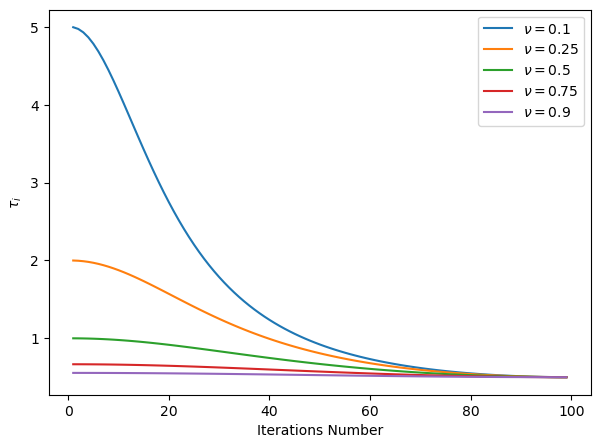

In [4]:
## Visualize how taui_sts varies with nu, as a function of iiter 

# Initialize 
iiter = np.arange(1, 100) # array of integers 
niter = 100 # number of iterations, Constant 
nu = [0.1, 0.25, 0.5, 0.75, 0.9] # Coefficient between (0,1)

# Arrays for plotting 
taui_nu_01 = np.zeros(len(iiter))
taui_nu_025 = np.zeros(len(iiter))
taui_nu_05 = np.zeros(len(iiter))
taui_nu_075 = np.zeros(len(iiter))
taui_nu_09 = np.zeros(len(iiter))

for i in range(len(iiter)): 
    taui_nu_01[i] = nm.taui_sts(nu[0], niter, iiter[i])
    taui_nu_025[i] = nm.taui_sts(nu[1], niter, iiter[i])
    taui_nu_05[i] = nm.taui_sts(nu[2], niter, iiter[i])
    taui_nu_075[i] = nm.taui_sts(nu[3], niter, iiter[i])
    taui_nu_09[i] = nm.taui_sts(nu[4], niter, iiter[i])

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(iiter, taui_nu_01,  label=rf"$\nu = {nu[0]}$")
ax.plot(iiter, taui_nu_025, label=rf"$\nu = {nu[1]}$")
ax.plot(iiter, taui_nu_05,  label=rf"$\nu = {nu[2]}$")
ax.plot(iiter, taui_nu_075, label=rf"$\nu = {nu[3]}$")
ax.plot(iiter, taui_nu_09,  label=rf"$\nu = {nu[4]}$")
ax.set_xlabel("Iterations Number")
ax.set_ylabel(r"$\tau_i$")
plt.legend()

print(taui_nu_01[-1])
print(taui_nu_025[-1])
print(taui_nu_05[-1])
print(taui_nu_075[-1])
print(taui_nu_09[-1])

<span style="color:pink">

For a constant number of iterations set to 100, $\tau_i$ will decrease as the iteratons number increases, converging towards 0.5. For varying $\nu$, we see how $\tau_i$ begins at a higher value for a lower $\nu$. 

Next, we want to visualize how `taui_sts` varies with $niter$. 

</span>

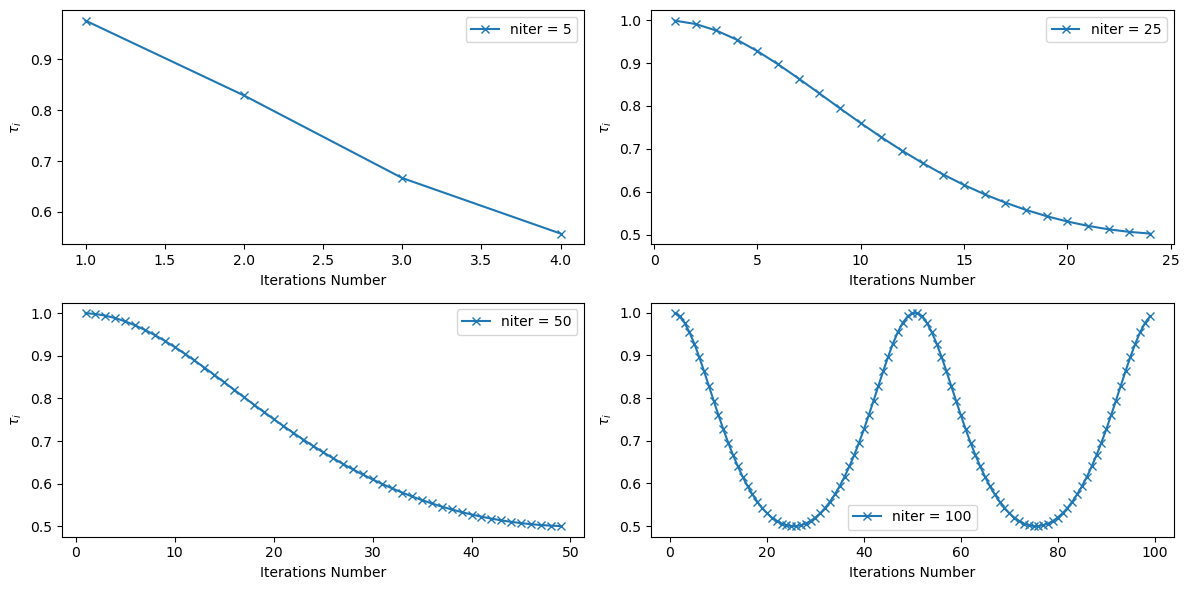

In [5]:
## Visualize how taui_sts varies with niter, as a function of iiter

# Initialize
nu = 0.5 # Coefficient between (0,1), constant
niter = [5, 25, 50, 100] # number of iterations
iiter5   = np.arange(1, niter[0])
iiter25  = np.arange(1, niter[1])
iiter50  = np.arange(1, niter[2])
iiter100 = np.arange(1, niter[3])

# Arrays for plotting 
taui_it_5 = nm.taui_sts(nu, niter[0], iiter5)
taui_it_25 = nm.taui_sts(nu, niter[1], iiter25)
taui_it_50 = nm.taui_sts(nu, niter[2], iiter50)
taui_it_100 = nm.taui_sts(nu, niter[1], iiter100)

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12, 6))

axes[0,0].plot(iiter5, taui_it_5, marker='x', label=rf"niter = {niter[0]}")
axes[0,1].plot(iiter25, taui_it_25, marker='x', label=rf"niter = {niter[1]}")
axes[1,0].plot(iiter50, taui_it_50, marker='x', label=rf"niter = {niter[2]}")
axes[1,1].plot(iiter100, taui_it_100, marker='x', label=rf"niter = {niter[3]}")         

for i in range(2):
    for j in range(2):
        # axes[i,j].grid(True)
        axes[i,j].set_xlabel("Iterations Number")
        axes[i,j].set_ylabel(r"$\tau_i$")
        axes[i,j].legend()

plt.tight_layout()

<span style="color:pink">

As the number of iterations increase, the curve becomes smoother due to the increases number of steps making each step smaller. 

After filling in `evol_sts`, we compare the solution with the analytical one for the final and intermediate STS steps. 
In order to do this we will use a Gaussian function and fit this to the STS curve. 

</span>

In [6]:
def gaussian(xx, A, mu, sigma, C): 
    """
    Gaussian function

    Parameters
    ----------
    xx : `array`
        Spatial axis. 
    A : `float`
        Amplitude. 
    mu : `float`
        Expected value. 
    sigma : `float`
        Standard deviation. 
    C : `int` or `float`
        Constant. 
    Returns 
    -------
    `array`
        Gaussian function
    """
    return A * np.exp(-0.5*(xx - mu)**2 / (sigma**2)) + C    

In [7]:
nump = 128
xx = np.arange(nump)/(nump-1.0) * (xf-x0) + x0
nt = 2000 

t_sts, unnt_sts = nm.evol_sts(xx, u(xx), nt, a=1, ddx=deriv_up_down, bnd_limits=[1,1], nu=0.1, n_sts=10)

# Using curve fit for the gaussian fit 
from scipy.optimize import curve_fit

In [8]:
# Initialize arrays for fitting
Amplitude = np.zeros(nt)
mu = np.zeros(nt)
sigma = np.zeros(nt)
C = np.zeros(nt)

for i in range(nt): 
    popt, pcov = curve_fit(gaussian, xx, unnt_sts[:,i]) # optimal values, covariance matrix

    Amplitude[i] = popt[0]
    mu[i]        = popt[1]
    sigma[i]     = popt[2]
    C[i]         = popt[3]

/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<span style="color:pink">

From the [wiki](https://github.com/AST-Course/AST5110/wiki/Self-similar-solution-for-parabolic-eq) we have that for this case, 

$$
u \propto t^{-1/2}, 
$$

and 

$$
R \propto t^{1/2}. 
$$

We combine these expressions with the amplitude (height of $u$) and standard deviation (width of $u$), respectively. 

</span>

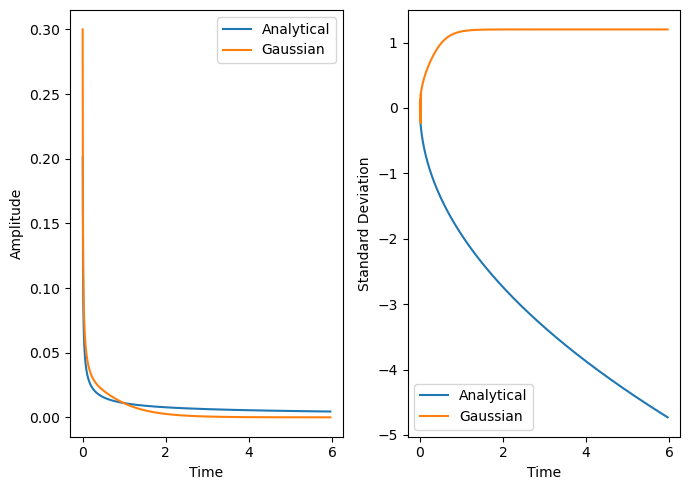

In [9]:
# Coefficients for analytical solution: 
A_idx = 1 # time index for the amplitude 
A_max_t0 = Amplitude[A_idx]/t_sts[A_idx]**(-0.5)

sig_idx = 1 # time index for the standard deviation
sigma_coeff = sigma[sig_idx]/t_sts[sig_idx]**(0.5)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))

ax1.plot(t_sts[1:], A_max_t0*t_sts[1:]**(-1/2), label="Analytical")
ax1.plot(t_sts[:], Amplitude[:], label="Gaussian")
ax1.set(xlabel="Time", ylabel="Amplitude")
ax1.legend()

ax2.plot(t_sts[1:], sigma_coeff*t_sts[1:]**(0.5), label="Analytical")
ax2.plot(t_sts, sigma, label="Gaussian")
ax2.set(xlabel="Time", ylabel="Standard Deviation")
ax2.legend()

plt.tight_layout()

<span style="color:pink">

We cut of everything after $t = 2$ to get a better comparison, and change the index for a better fit. 

</span>

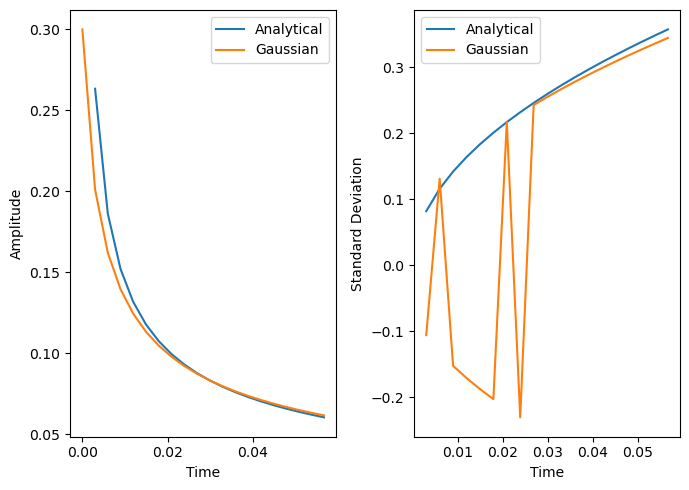

In [10]:
# Coefficients for analytical solution: 
A_idx = 10 # time index for the amplitude 
A_max_t0 = Amplitude[A_idx]/t_sts[A_idx]**(-0.5)

sig_idx = 7 # time index for the standard deviation
sigma_coeff = sigma[sig_idx]/t_sts[sig_idx]**(0.5)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))
ax1.plot(t_sts[1:20], A_max_t0*t_sts[1:20]**(-1/2), label="Analytical")
ax1.plot(t_sts[:20], Amplitude[:20], label="Gaussian")
ax1.set(xlabel="Time", ylabel="Amplitude")
ax1.legend()

ax2.plot(t_sts[1:20], sigma_coeff*t_sts[1:20]**(0.5), label="Analytical")
ax2.plot(t_sts[1:20], sigma[1:20], label="Gaussian")
ax2.set(xlabel="Time", ylabel="Standard Deviation")
ax2.legend()

plt.tight_layout()

<span style="color:pink">

We can then animate the analytical solution with the STS to see how they compare. 

</span>

In [11]:
M=100

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

def init(): 
    axes.plot(xx, gaussian(xx, A_max_t0*t_sts[0]**(-1/2),0 , sigma_coeff*t_sts[0]**0.5, 0))
    axes.plot(xx, unnt_sts[:,0])

def animate(i):
    axes.clear()
    axes.plot(xx, unnt_sts[:,:M][:,i], label="sts")
    axes.plot(xx, gaussian(xx, A_max_t0*t_sts[i]**(-1/2), 0 , sigma_coeff*t_sts[i]**0.5, 0), label="Analytical")
    axes.set_title('t=%.2f'%t_sts[i])
    axes.grid()
    axes.set_ylim((0, 0.31))
    axes.legend()
    
anim = FuncAnimation(fig, animate, interval=50, frames=len(t_sts[:M]), init_func=init)
plt.close()
HTML(anim.to_jshtml())

/tmp/ipykernel_33661/3104143298.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  axes.plot(xx, gaussian(xx, A_max_t0*t_sts[0]**(-1/2),0 , sigma_coeff*t_sts[0]**0.5, 0))
/tmp/ipykernel_33661/1243884920.py:22: RuntimeWarning: divide by zero encountered in divide
  return A * np.exp(-0.5*(xx - mu)**2 / (sigma**2)) + C
/tmp/ipykernel_33661/1243884920.py:22: RuntimeWarning: invalid value encountered in multiply
  return A * np.exp(-0.5*(xx - mu)**2 / (sigma**2)) + C
/tmp/ipykernel_33661/3104143298.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  axes.plot(xx, gaussian(xx, A_max_t0*t_sts[i]**(-1/2), 0 , sigma_coeff*t_sts[i]**0.5, 0), label="Analytical")
/tmp/ipykernel_33661/1243884920.py:22: RuntimeWarning: divide by zero encountered in divide
  return A * np.exp(-0.5*(xx - mu)**2 / (sigma**2)) + C
/tmp/ipykernel_33661/1243884920.py:22: RuntimeWarning: invalid value encountered in multiply
  return A * np.exp(-0.5*(xx - mu)**2 / (sigma**2)) + C


<span style="color:pink">

The comparison looks mostly good. The amplitudes are somewhat different for the first time steps, as expected from the plot showing the comparison between the analytical amplitude and corresponding gaussian fit. There, we saw that the fit is best for later time steps. As the solution evolves in time it gets better. 

</span>

<span style="color:pink">

It is interesting to analyze the timesteps, and look at what happens inbetween and how this depends on the substeps. 

In the comparison visualized in the animation above, the sts solution is compared using every timestep. 

</span>